# Recommender Systems

In this lab, we'll be using Keras to build a recommender system. We'll be using the MovieLens dataset, a common benchmark dataset for recommender systems.

MovieLens is a web-based recommender system and virtual community that recommends movies for its users to watch, based on their film preferences using collaborative filtering of members' movie ratings and movie reviews. You can check out the website here: https://movielens.org/

We will download a subset of the dataset containing 100k ratings. There are tens of millions of ratings in the full dataset, spanning hundreds of thousands of users and movies. The subset we'll be using is a good example to demonstrate the concepts in this lab.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from zipfile import ZipFile
from urllib.request import urlretrieve
from pathlib import Path

ML_100K_URL = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
ML_100K_FILENAME = Path("ml-100k.zip")
ML_100K_FOLDER = Path("ml-100k")

if not ML_100K_FOLDER.exists():
    if not ML_100K_FILENAME.exists():
        urlretrieve(ML_100K_URL, ML_100K_FILENAME.name)
    with ZipFile(ML_100K_FILENAME.name) as zips: #zips ???
        zips.extractall() # zips ???

The goal of MovieLens is to enable models to predict the rating a user would give to a movie they have not yet watched. This is a classic example of a recommendation system. The dataset is huge, and contains many parts giving information about the movies, the users, and the ratings. To begin with, we will look at the ratings file. Each line in the ratings file (u.data) is formatted as:

`user_id, item_id, rating, timestamp`

Which tells us a single user's rating of a single movie.

We will start by loading the ratings data into a pandas dataframe and then take a look at the first few rows. If you haven't used Pandas before, it's an extremely powerful library for dealing with tabular data. You can think of it as a Python version of Excel.

In [2]:
import pandas as pd

raw_ratings = pd.read_csv(ML_100K_FOLDER / "u.data", sep='\t',
                          names=["user_id", "item_id", "rating", "timestamp"])
raw_ratings

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


The second file we'll look at is the movie metadata. This file (u.item) contains information about each movie, including the title and release date. Each line in the file is formatted as:

`movie_id | movie_title | release_date | video_release_date | IMDb_URL | unknown | Action | Adventure | Animation | Children's | Comedy | Crime | Documentary | Drama | Fantasy | Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western`

As you can see, the genres are binary variables. As with one-hot encoding, a 1 indicates that the movie is of that genre, and a 0 indicates that it is not. We aren't going to work with the genre data in this lab, but it's easy to imagine that it could be useful in a real-world recommendation system.

In [3]:
columns_to_keep = ['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
items = pd.read_csv(ML_100K_FOLDER / "u.item", sep='|', names=columns_to_keep,
                   encoding='latin-1', usecols=range(5))

columns_with_genres = ['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url',
                       'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime',
                       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
                       'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

# Read the file with updated columns
items_with_genre = pd.read_csv(ML_100K_FOLDER / "u.item", sep='|', names=columns_with_genres,
                    encoding='latin-1', usecols=range(len(columns_with_genres)))
items_with_genre

,item_id,title,release_date,video_release_date,imdb_url,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


By default, the `release_date` column is a string. We can convert it to a `datetime` object using the `pd.to_datetime` function. This will make it easier to work with in the future (if we want to do things like check which date came first, for example).

We can also extract the year from the date and store it in a separate column. This will make it easier to do things like plot the number of movies released each year.

In [4]:
items['release_date'] = pd.to_datetime(items['release_date']) # Pandas makes this easy!
items['release_year'] = items['release_date'].dt.year # For later use

items_with_genre['release_date'] = pd.to_datetime(items_with_genre['release_date']) # Pandas makes this easy!
items_with_genre['release_year'] = items_with_genre['release_date'].dt.year # For later use

For our purposes, it will be easier to work with the data if we merge our two dataframes into a single dataframe. We can do this using the `merge` method. We'll merge the `items` dataframe into the `raw_ratings` dataframe, using the `item_id` column as the key. This will add the movie title and release year to each rating.

In [5]:
all_ratings = pd.merge(items, raw_ratings)
all_ratings_with_genre = pd.merge(items_with_genre, raw_ratings)

In [6]:
all_ratings_with_genre.head()

,item_id,title,release_date,video_release_date,imdb_url,Action,Adventure,Animation,Children's,Comedy,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,release_year,user_id,rating,timestamp
0,1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,1995.0,308,4,887736532
1,1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,1995.0,287,5,875334088
2,1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,1995.0,148,4,877019411
3,1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,1995.0,280,4,891700426
4,1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,1995.0,66,3,883601324


### Data preprocessing

It's always important to understand the data you've collected. Thankfully, Pandas continues to make this easy for us. Using the `describe` method, we can get a quick statistical summary of the data.

In [7]:
all_ratings_with_genre.describe()

,item_id,release_date,video_release_date,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,release_year,user_id,rating,timestamp
count,100000.000000,99991,0.0,100000.0000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.00000,100000.00000,100000.000000,99991.000000,100000.00000,100000.000000,1.000000e+05
mean,425.530130,1988-02-09 00:43:11.369223296,NaN,0.0001,0.255890,0.137530,0.036050,0.071820,0.298320,0.080550,...,0.049540,0.052450,0.194610,0.12730,0.21872,0.093980,1987.956216,462.48475,3.529860,8.835289e+08
min,1.000000,1922-01-01 00:00:00,NaN,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,1922.000000,1.00000,1.000000,8.747247e+08
25%,175.000000,1986-01-01 00:00:00,NaN,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,1986.000000,254.00000,3.000000,8.794487e+08
50%,322.000000,1994-01-01 00:00:00,NaN,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,1994.000000,447.00000,4.000000,8.828269e+08
75%,631.000000,1996-09-28 00:00:00,NaN,0.0000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,1996.000000,682.00000,4.000000,8.882600e+08
max,1682.000000,1998-10-23 00:00:00,NaN,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1998.000000,943.00000,5.000000,8.932866e+08
std,330.798356,NaN,NaN,0.0100,0.436362,0.344408,0.186416,0.258191,0.457523,0.272144,...,0.216994,0.222934,0.395902,0.33331,0.41338,0.291802,14.155523,266.61442,1.125674,5.343856e+06


Let's do a bit more pandas magic to compute the popularity of each movie (number of ratings). We will use the `groupby` method to group the dataframe by the `item_id` column and then use the `size` method to compute the number of ratings for each movie. We will use the `reset_index` method to convert the resulting Series into a dataframe with an `item_id` column.

In [8]:
popularity = all_ratings.groupby('item_id').size().reset_index(name='popularity')
items = pd.merge(popularity, items)

popularity_with_genre = all_ratings_with_genre.groupby('item_id').size().reset_index(name='popularity')
items_with_genre = pd.merge(popularity_with_genre, items_with_genre)


<Axes: ylabel='Frequency'>

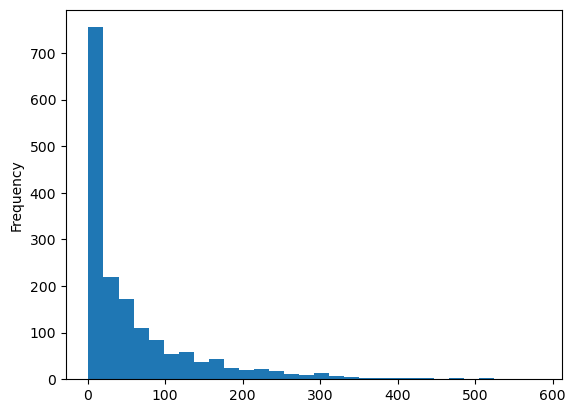

In [9]:
items_with_genre['popularity'].plot.hist(bins=30)

In [10]:
(items['popularity'] == 1).sum() # Number of movies with only one rating

141

In [11]:
items.nlargest(10, 'popularity')['title'] # Get the 10 most popular movies

49                  Star Wars (1977)
257                   Contact (1997)
99                      Fargo (1996)
180        Return of the Jedi (1983)
293                 Liar Liar (1997)
285      English Patient, The (1996)
287                    Scream (1996)
0                   Toy Story (1995)
299             Air Force One (1997)
120    Independence Day (ID4) (1996)
Name: title, dtype: object

In [12]:
all_ratings = pd.merge(popularity, all_ratings)
all_ratings_with_genre = pd.merge(popularity_with_genre, all_ratings_with_genre)



all_ratings_with_genre.describe()

,item_id,popularity,release_date,video_release_date,Action,Adventure,Animation,Children's,Comedy,Crime,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,release_year,user_id,rating,timestamp
count,100000.000000,100000.000000,99991,0.0,100000.0000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.00000,100000.00000,100000.000000,99991.000000,100000.00000,100000.000000,1.000000e+05
mean,425.530130,168.071900,1988-02-09 00:43:11.369223296,NaN,0.0001,0.255890,0.137530,0.036050,0.071820,0.298320,...,0.049540,0.052450,0.194610,0.12730,0.21872,0.093980,1987.956216,462.48475,3.529860,8.835289e+08
min,1.000000,1.000000,1922-01-01 00:00:00,NaN,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,1922.000000,1.00000,1.000000,8.747247e+08
25%,175.000000,71.000000,1986-01-01 00:00:00,NaN,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,1986.000000,254.00000,3.000000,8.794487e+08
50%,322.000000,145.000000,1994-01-01 00:00:00,NaN,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,1994.000000,447.00000,4.000000,8.828269e+08
75%,631.000000,239.000000,1996-09-28 00:00:00,NaN,0.0000,1.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,1996.000000,682.00000,4.000000,8.882600e+08
max,1682.000000,583.000000,1998-10-23 00:00:00,NaN,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1998.000000,943.00000,5.000000,8.932866e+08
std,330.798356,121.784558,NaN,NaN,0.0100,0.436362,0.344408,0.186416,0.258191,0.457523,...,0.216994,0.222934,0.395902,0.33331,0.41338,0.291802,14.155523,266.61442,1.125674,5.343856e+06


In [13]:
all_ratings_with_genre = all_ratings_with_genre[all_ratings_with_genre['popularity'] >= 70]
all_ratings_with_genre.describe()

,item_id,popularity,release_date,video_release_date,Action,Adventure,Animation,Children's,Comedy,Crime,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,release_year,user_id,rating,timestamp
count,75427.000000,75427.000000,75427,0.0,75427.0,75427.000000,75427.000000,75427.000000,75427.000000,75427.000000,...,75427.000000,75427.000000,75427.000000,75427.000000,75427.000000,75427.000000,75427.000000,75427.000000,75427.000000,7.542700e+04
mean,318.884100,210.093163,1988-01-01 09:39:40.160950272,NaN,0.0,0.292839,0.156814,0.037586,0.067071,0.288478,...,0.053509,0.056399,0.210084,0.150172,0.239967,0.116311,1987.846474,464.133414,3.657749,8.834171e+08
min,1.000000,70.000000,1933-01-01 00:00:00,NaN,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1933.000000,1.000000,1.000000,8.747247e+08
25%,144.000000,125.000000,1985-01-01 00:00:00,NaN,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1985.000000,252.000000,3.000000,8.794448e+08
50%,264.000000,180.000000,1994-01-01 00:00:00,NaN,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1994.000000,450.000000,4.000000,8.826076e+08
75%,471.000000,268.000000,1996-10-04 00:00:00,NaN,0.0,1.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1996.000000,686.000000,4.000000,8.881927e+08
max,1101.000000,583.000000,1998-10-23 00:00:00,NaN,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1998.000000,943.000000,5.000000,8.932866e+08
std,235.377824,111.154476,NaN,NaN,0.0,0.455068,0.363628,0.190194,0.250147,0.453057,...,0.225047,0.230692,0.407371,0.357242,0.427066,0.320600,13.610306,267.882255,1.070028,5.330451e+06


In [14]:
all_ratings_with_genre.groupby('user_id').size().describe()

count    943.000000
mean      79.986214
std       67.593113
min        8.000000
25%       27.000000
50%       54.000000
75%      117.000000
max      345.000000
dtype: float64

In [15]:
user_rating_counts = all_ratings_with_genre.groupby('user_id').size()
users_to_exclude = user_rating_counts[user_rating_counts < 27].index
all_ratings_with_genre = all_ratings_with_genre[~all_ratings_with_genre['user_id'].isin(users_to_exclude)]
#print(filtered_all_ratings.describe())

In [16]:
all_ratings_with_genre.describe()

,item_id,popularity,release_date,video_release_date,Action,Adventure,Animation,Children's,Comedy,Crime,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,release_year,user_id,rating,timestamp
count,70860.000000,70860.000000,70860,0.0,70860.0,70860.000000,70860.00000,70860.000000,70860.000000,70860.000000,...,70860.000000,70860.000000,70860.000000,70860.000000,70860.000000,70860.000000,70860.000000,70860.000000,70860.000000,7.086000e+04
mean,318.092859,207.705236,1987-08-19 19:26:22.049110848,NaN,0.0,0.293649,0.15985,0.038936,0.068290,0.292069,...,0.054826,0.052667,0.208736,0.151143,0.234434,0.115467,1987.484745,463.127815,3.662221,8.833084e+08
min,1.000000,70.000000,1933-01-01 00:00:00,NaN,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1933.000000,1.000000,1.000000,8.747247e+08
25%,137.000000,124.000000,1985-01-01 00:00:00,NaN,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1985.000000,254.000000,3.000000,8.794413e+08
50%,257.000000,179.000000,1994-01-01 00:00:00,NaN,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1994.000000,450.000000,4.000000,8.823989e+08
75%,473.000000,267.000000,1996-07-19 00:00:00,NaN,0.0,1.000000,0.00000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1996.000000,682.000000,4.000000,8.879273e+08
max,1101.000000,583.000000,1998-10-23 00:00:00,NaN,0.0,1.000000,1.00000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1998.000000,943.000000,5.000000,8.932866e+08
std,237.462849,109.257112,NaN,NaN,0.0,0.455436,0.36647,0.193444,0.252244,0.454717,...,0.227643,0.223370,0.406408,0.358191,0.423648,0.319587,13.760304,267.467495,1.065730,5.323304e+06


**Quick Exercise**:

As we have seen, the `groupby` method is a powerful tool to quickly compute statistics on the data. Use it to compute the average rating for each movie.

**Hint**: you can use the `mean` method after the `groupby` method.

In [17]:
# Your code here
mean_rating = all_ratings.groupby('item_id')['rating'].mean().reset_index(name='mean_rating')

all_ratings = all_ratings.merge(mean_rating, on='item_id')
all_ratings

,item_id,popularity,title,release_date,video_release_date,imdb_url,release_year,user_id,rating,timestamp,mean_rating
0,1,452,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,308,4,887736532,3.878319
1,1,452,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,287,5,875334088,3.878319
2,1,452,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,148,4,877019411,3.878319
3,1,452,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,280,4,891700426,3.878319
4,1,452,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,66,3,883601324,3.878319
...,...,...,...,...,...,...,...,...,...,...,...
99995,1678,1,Mat' i syn (1997),1998-02-06,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,1998.0,863,1,889289570,1.000000
99996,1679,1,B. Monkey (1998),1998-02-06,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,1998.0,863,3,889289491,3.000000
99997,1680,1,Sliding Doors (1998),1998-01-01,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),1998.0,863,2,889289570,2.000000
99998,1681,1,You So Crazy (1994),1994-01-01,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,1994.0,896,3,887160722,3.000000


Let's split the enriched data in a train / test split to make it possible to do predictive modeling:

In [18]:
import numpy as np
from sklearn.model_selection import train_test_split

ratings_train, ratings_test = train_test_split(
    all_ratings, test_size=0.2, random_state=0)

user_id_train = np.array(ratings_train['user_id'])
item_id_train = np.array(ratings_train['item_id'])
rating_train = np.array(ratings_train['rating'])

user_id_test = np.array(ratings_test['user_id'])
item_id_test = np.array(ratings_test['item_id'])
rating_test = np.array(ratings_test['rating'])

# Define the columns to keep as one-hot encoded genre columns
genre_columns = ['Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime',
                  'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
                  'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

# Filter columns to include only genre columns
columns_with_genres = genre_columns

# Splitting data
ratings_train_with_genre, ratings_test_with_genre = train_test_split(all_ratings_with_genre, test_size=0.2, random_state=0)

# Extracting training data
user_id_train_with_genre = np.array(ratings_train_with_genre['user_id'], dtype=np.int32)
item_id_train_with_genre = np.array(ratings_train_with_genre['item_id'], dtype=np.int32)
genres_train_with_genre = np.array(ratings_train_with_genre[columns_with_genres], dtype=np.float32)  # Ensure correct dtype
rating_train_with_genre = np.array(ratings_train_with_genre['rating'], dtype=np.float32)  # Ensure correct dtype

# Extracting test data
user_id_test_with_genre = np.array(ratings_test_with_genre['user_id'], dtype=np.int32)
item_id_test_with_genre = np.array(ratings_test_with_genre['item_id'], dtype=np.int32)
genres_test_with_genre = np.array(ratings_test_with_genre[columns_with_genres], dtype=np.float32)  # Ensure correct dtype
rating_test_with_genre = np.array(ratings_test_with_genre['rating'], dtype=np.float32)  # Ensure correct dtype




# Explicit feedback: supervised ratings prediction

Now let's begin to do some recommendation! We will build a model that takes a user and a movie as input and outputs a predicted rating. We will be taking advantage of embeddings to represent users and movies. That means that each movie and user will have an abstract representation in a continuous vector space. The model will learn these representations based on the ratings.

## Predictive ratings  as a regression problem

The following code implements the following architecture:

<img src="https://raw.githubusercontent.com/UofT-DSI/deep_learning/main/notebooks/images/rec_archi_1.svg" style="width: 600px;" />

In [19]:
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout
from tensorflow.keras.layers import Dot
from tensorflow.keras.models import Model

In [25]:
# For each sample we input the integer identifiers
# of a single user and a single item
##### Base model
class RegressionModel(Model):
    def __init__(self, embedding_size, max_user_id, max_item_id):
        super().__init__()
        
        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user_id + 1,
                                        input_length=1,
                                        name='user_embedding')
        self.item_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_item_id + 1,
                                        input_length=1,
                                        name='item_embedding')
        
        # The following two layers don't have parameters.
        self.flatten = Flatten()
        self.dot = Dot(axes=1)
        
    def call(self, inputs):
        user_inputs = inputs[0]
        item_inputs = inputs[1]
        
        user_vecs = self.flatten(self.user_embedding(user_inputs))
        item_vecs = self.flatten(self.item_embedding(item_inputs))
        
        y = self.dot([user_vecs, item_vecs])
        return y


model = RegressionModel(embedding_size=64, max_user_id=all_ratings['user_id'].max(), max_item_id=all_ratings['item_id'].max())
model.compile(optimizer="adam", loss='mae')


### Monitoring runs

When training a model with Keras, we get a `history` object back that contains lots of information about the training run. We can use this to plot the training and validation loss to see how the model has improved during training.

In [26]:
%%time

# Training the model

history = model.fit([user_id_train, item_id_train], rating_train,
                      batch_size=64, epochs=10, validation_split=0.1, shuffle=True)

Epoch 1/10
1125/1125 [==============================] - 4s 3ms/step - loss: 2.6109 - val_loss: 1.0405
Epoch 2/10
1125/1125 [==============================] - 3s 3ms/step - loss: 0.8469 - val_loss: 0.7908
Epoch 3/10
1125/1125 [==============================] - 3s 3ms/step - loss: 0.7546 - val_loss: 0.7673
Epoch 4/10
1125/1125 [==============================] - 3s 3ms/step - loss: 0.7275 - val_loss: 0.7566
Epoch 5/10
1125/1125 [==============================] - 4s 3ms/step - loss: 0.7072 - val_loss: 0.7502
Epoch 6/10
1125/1125 [==============================] - 4s 3ms/step - loss: 0.6863 - val_loss: 0.7435
Epoch 7/10
1125/1125 [==============================] - 4s 4ms/step - loss: 0.6648 - val_loss: 0.7443
Epoch 8/10
1125/1125 [==============================] - 4s 3ms/step - loss: 0.6432 - val_loss: 0.7408
Epoch 9/10
1125/1125 [==============================] - 4s 3ms/step - loss: 0.6194 - val_loss: 0.7428
Epoch 10/10
1125/1125 [==============================] - 3s 3ms/step - loss: 0.595

Text(0.5, 1.0, 'Loss')

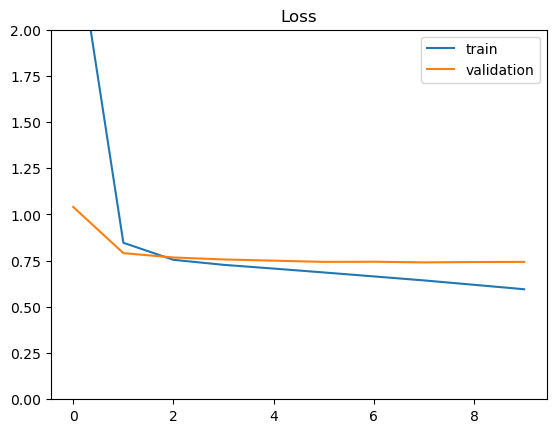

In [27]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss')

**Questions**:

- Does it look like our model has overfit? Why or why not?
- Suggest something we could do to prevent overfitting.


Now that the model is trained, let's check out the quality of predictions:

In [28]:
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(4, 4))
    plt.xlim(-1, 6)
    plt.xlabel("True rating")
    plt.ylim(-1, 6)
    plt.ylabel("Predicted rating")
    plt.scatter(y_true, y_pred, s=60, alpha=0.01)

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predict using the model with genre features
test_preds = model.predict([user_id_test, item_id_test])

# Calculate Mean Squared Error (MSE) and Mean Absolute Error (MAE)
mse = mean_squared_error(rating_test, test_preds)
mae = mean_absolute_error(rating_test, test_preds)

print("Final test MSE: %0.3f" % mse)
print("Final test MAE: %0.3f" % mae)

625/625 [==============================] - 1s 2ms/step
Final test MSE: 0.905
Final test MAE: 0.735


This graph shows us the range of predicted ratings our model gives, organized by the true rating. We can see that generally, the higher the true rating the higher the predicted rating, although there is quite a range of predictions for each instance. That's okay - our model is very simple, and human preferences are very complex!

Taking a look at the Mean Absolute Error, hopefully you got something around 0.75. This means that, on average, our predicted ratings are about 0.75 stars off from the true ratings. This is a pretty good result for a first attempt. We could probably do better with a more complex model, but we'll leave that for another time.

### Model Embeddings

Our model was built with two embedding layers. These layers have learned a representation of both the users and the movies in our dataset. We can extract these representations and use them to find similar movies or users. We can also do interesting exploratory analysis, like finding the most popular movies among our users, or finding the users that are most interested in a given movie.

In [30]:
# weights and shape
weights = model.get_weights()
[w.shape for w in weights]

[(944, 64), (1683, 64)]

In [31]:
user_embeddings = weights[0]
item_embeddings = weights[1]

In [32]:
item_id = 181
indexed_items = items.set_index('item_id')
print(f"Title for item_id={item_id}: {indexed_items['title'][item_id]}")

Title for item_id=181: Return of the Jedi (1983)


In [33]:
print(f"Embedding vector for item_id={item_id}")
print(item_embeddings[item_id])
print("shape:", item_embeddings[item_id].shape)

Embedding vector for item_id=181
[ 0.15278308 -0.09308739 -0.45109347 -0.23241428  0.4046107  -0.61134404
  0.49260795  0.43350163 -0.49655944  0.05798693  0.08951165  0.4371985
 -0.42908382 -0.20207083  0.33225313  0.47582552 -0.04125114 -0.07395916
  0.42516792  0.30951536 -0.20706521  0.2655185  -0.16968024 -0.11096086
  0.46198425  0.16517508 -0.15937725  0.3868035   0.42946488  0.28046113
 -0.48184457 -0.32667416 -0.0318576   0.2749497  -0.02698657  0.16998927
  0.3946332  -0.35705775  0.15539595  0.4063909   0.46623912 -0.32166305
 -0.36504567  0.4244795  -0.46099076 -0.4310101   0.40237737  0.24822934
 -0.10385579  0.10340498  0.00349375 -0.03693409  0.2951398   0.25410923
 -0.42747214  0.34366587  0.06550103 -0.0530806  -0.35026217 -0.18176493
 -0.26270646 -0.24037097  0.28668728  0.42730442]
shape: (64,)


As we discussed in lecture, our embeddings are not directly interpretable - we can't look at, say, a value of 0.297 in the embedding vector and say "this means that the movie is a drama". As an aside, there is a field of research dedicated to making _interpretable_ embeddings, but it's not something we'll cover in this course.

### Finding our most similar items

Now we can have some fun, investigating the embeddings we've learned. We can start by finding the most similar items to a given item. We can do this by computing the cosine similarity between the item's embedding and the embedding of every other item. We can use the `cosine_similarity` function from `sklearn` to do this.

In [34]:
from sklearn.metrics.pairwise import cosine_similarity

def cosine(a, b):
    # Reshape to the shape our function expects
    a = a.reshape(1, -1)
    b = b.reshape(1, -1)
    return cosine_similarity(a, b)[0, 0]

In [35]:
def print_similarity(item_a, item_b, item_embeddings, titles):
    print(titles[item_a])
    print(titles[item_b])
    similarity = cosine(item_embeddings[item_a],
                        item_embeddings[item_b])
    print(f"Cosine similarity: {similarity:.3}")

print_similarity(50, 181, item_embeddings, indexed_items["title"])

Star Wars (1977)
Return of the Jedi (1983)
Cosine similarity: 0.91


It makes sense that the original Star Wars, and its later sequel Return of the Jedi have a high similarity. Let's try some other examples:

In [36]:
print_similarity(181, 288, item_embeddings, indexed_items["title"])

Return of the Jedi (1983)
Scream (1996)
Cosine similarity: 0.751


In [37]:
print_similarity(181, 1, item_embeddings, indexed_items["title"])

Return of the Jedi (1983)
Toy Story (1995)
Cosine similarity: 0.803


In [38]:
print_similarity(181, 181, item_embeddings, indexed_items["title"])

Return of the Jedi (1983)
Return of the Jedi (1983)
Cosine similarity: 1.0


*Quick Exercise*:

- Find some other films and compare their similarity. Do the results make sense to you? Can you find a pair of films that are very _dissimilar_?

In [39]:
# Code to help you search for a movie title
partial_title = "Jedi"
indexed_items[indexed_items['title'].str.contains(partial_title)]

# Your code here
partial_title = "Jurassic"
#indexed_items[indexed_items['title'].str.contains(partial_title)]['item_id']
filtered_items = indexed_items[indexed_items['title'].str.contains(partial_title, case=False, na=False)]

#print_similarity(filtered_item.loc[0].index, filtered_item.loc[1].index, item_embeddings, indexed_items["title"])
if len(filtered_items) >= 2:
    print_similarity(filtered_items.index[0], filtered_items.index[1], item_embeddings, indexed_items["title"])
else:
    print("Not enough items found with the partial title:", partial_title)

Jurassic Park (1993)
Lost World: Jurassic Park, The (1997)
Cosine similarity: 0.86


Sometimes, even without knowing anything about a user, we can recommend films by asking them about a film that they do like. The code below compares the similarity of a given film to all others, and returns the most similar films.

In [40]:
def most_similar(item_id, item_embeddings, titles,
                 top_n=30):
    # Compute the cosine similarity between the item and all other items
    sims = cosine_similarity(item_embeddings[item_id].reshape(1, -1),
                             item_embeddings).ravel()

    # [::-1] makes it possible to reverse the order of a numpy
    # array, this is required because most similar items have
    # a larger cosine similarity value
    sorted_indexes = np.argsort(sims)[::-1]
    idxs = sorted_indexes[0:top_n]
    return list(zip(idxs, titles[idxs], sims[idxs])) # !!! if error -> change zip to zips at the top of notebook and restart kernal

# Find the most similar films to "Star Wars"
most_similar(50, item_embeddings, indexed_items["title"], top_n=10)

[(50, 'Star Wars (1977)', 1.0),
 (172, 'Empire Strikes Back, The (1980)', 0.91859305),
 (181, 'Return of the Jedi (1983)', 0.90953344),
 (174, 'Raiders of the Lost Ark (1981)', 0.8847269),
 (404, 'Pinocchio (1940)', 0.8793278),
 (228, 'Star Trek: The Wrath of Khan (1982)', 0.8681582),
 (12, 'Usual Suspects, The (1995)', 0.86326027),
 (204, 'Back to the Future (1985)', 0.8553087),
 (430, 'Duck Soup (1933)', 0.85136306),
 (227, 'Star Trek VI: The Undiscovered Country (1991)', 0.8513193)]

In [41]:
# Find the most similar films to "Star Trek VI: The Undiscovered Country"
most_similar(227, item_embeddings, indexed_items["title"], top_n=10)

[(227, 'Star Trek VI: The Undiscovered Country (1991)', 1.0),
 (228, 'Star Trek: The Wrath of Khan (1982)', 0.90223825),
 (230, 'Star Trek IV: The Voyage Home (1986)', 0.8795486),
 (208, 'Young Frankenstein (1974)', 0.8783523),
 (679, 'Conan the Barbarian (1981)', 0.87535936),
 (181, 'Return of the Jedi (1983)', 0.8737408),
 (109, 'Mystery Science Theater 3000: The Movie (1996)', 0.87198913),
 (257, 'Men in Black (1997)', 0.87149143),
 (222, 'Star Trek: First Contact (1996)', 0.87143445),
 (1485, 'Colonel Chabert, Le (1994)', 0.87023044)]

The similarities do not always make sense: the number of ratings is low and the embedding  does not automatically capture semantic relationships in that context. Better representations arise with higher number of ratings, and less overfitting  in models or maybe better loss function, such as those based on implicit feedback.

### Visualizing embeddings using TSNE

The [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) algorithm enables us to visualize high dimensional vectors in a 2D space by preserving local neighborhoods. We can use it to get a 2D visualization of the item embeddings and see if similar items are close in the embedding space.

In [42]:
from sklearn.manifold import TSNE

item_tsne = TSNE(learning_rate="auto", init="pca", perplexity=30).fit_transform(item_embeddings)

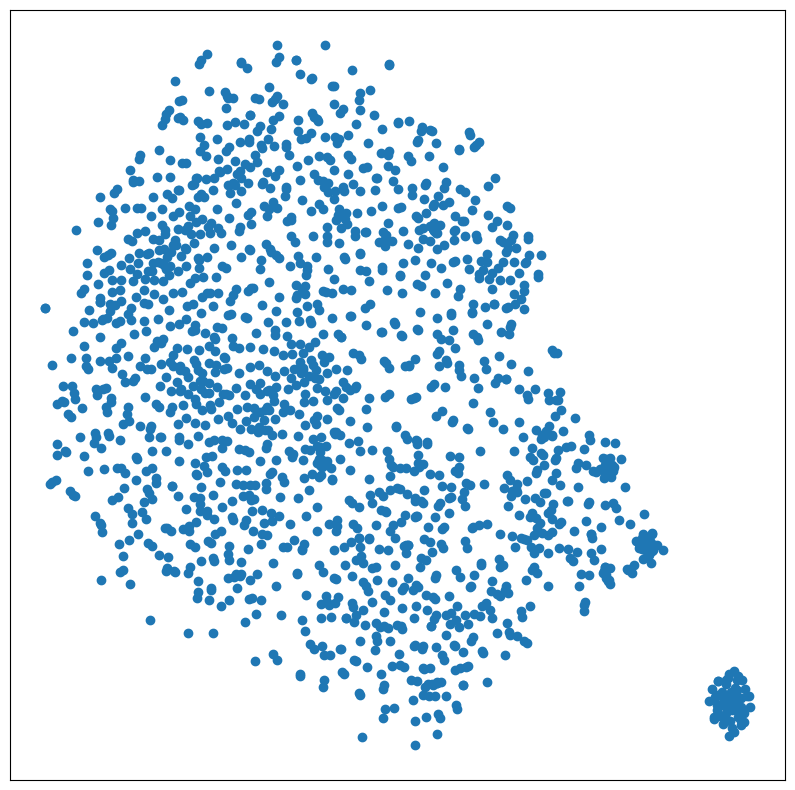

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(item_tsne[:, 0], item_tsne[:, 1]);
plt.xticks(()); plt.yticks(());
plt.show()

In [44]:
import plotly.express as px

tsne_df = pd.DataFrame(item_tsne, columns=["tsne_1", "tsne_2"])
tsne_df["item_id"] = np.arange(item_tsne.shape[0])
tsne_df = tsne_df.merge(items.reset_index())

px.scatter(tsne_df, x="tsne_1", y="tsne_2",
           color="popularity",
           hover_data=["item_id", "title", "popularity"])

### Exercises

 - Add another layer to the neural network and retrain, compare train/test error.
 - Try adding more dropout and change layer sizes.


### A recommendation function for a given user

Once the model is trained, the system can be used to recommend a few items for a user that they haven't seen before. The following code does that.

- we use the `model.predict` to compute the ratings a user would have given to all items
- we build a function that sorts these items and excludes those the user has already seen.

In [45]:
def recommend(user_id, top_n=10):
    item_ids = range(1, items['item_id'].max())
    seen_mask = all_ratings["user_id"] == user_id
    seen_movies = set(all_ratings[seen_mask]["item_id"])
    item_ids = list(filter(lambda x: x not in seen_movies, item_ids))

    user = np.zeros_like(item_ids)
    user[:len(item_ids)] = user_id
    items_ = np.array(item_ids)
    ratings = model.predict([user, items_]).flatten()
    top_items = ratings.argsort()[-top_n:][::-1]
    return [(indexed_items.loc[item_id]["title"], ratings[item_id]) for item_id in top_items]

In [46]:
for title, pred_rating in recommend(5):
    print("    %0.1f: %s" % (pred_rating, title))

48/48 [==============================] - 0s 2ms/step
    4.0: 20,000 Leagues Under the Sea (1954)
    4.0: Eat Drink Man Woman (1994)
    4.0: Robert A. Heinlein's The Puppet Masters (1994)
    4.0: Legends of the Fall (1994)
    4.0: Dead Man Walking (1995)
    3.9: Devil's Advocate, The (1997)
    3.9: Letter From Death Row, A (1998)
    3.9: Faster Pussycat! Kill! Kill! (1965)
    3.8: Clockwork Orange, A (1971)
    3.8: Rock, The (1996)


### Exercises

- Try modifying our neural network to improve recommendation. You could try adding more layers, or using a different loss function.
- Your goal is to improve the Mean Absolute Error on the test set. Show the results of your best model.

In [122]:
# Extend and improve the model below
##### More complex, but not really better model
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, Flatten, Dropout, Dot, Concatenate
from tensorflow.keras.regularizers import l2

class RegressionModel_WithGenres(tf.keras.Model):
    def __init__(self, embedding_size, max_user_id, max_item_id, num_genre_features):
        super().__init__()

        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user_id + 1,
                                        input_length=1,
                                        name='user_embedding')
        self.item_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_item_id + 1,
                                        input_length=1,
                                        name='item_embedding')

        self.flatten = Flatten()
        self.dot = Dot(axes=1)

        # Increased complexity and added regularization
        self.user_transform_layer = Dense(64, activation='relu', kernel_regularizer=l2(0.01))
        self.item_transform_layer = Dense(64, activation='relu', kernel_regularizer=l2(0.01))
        self.dropout = Dropout(0.1)

        # Additional dense layers
        self.additional_layer1 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))
        self.additional_layer2 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))

        # Genre processing
        self.genre_dense = Dense(64, activation='relu', kernel_regularizer=l2(0.01))
        self.num_genre_features = num_genre_features

    def call(self, inputs):
        user_inputs = inputs[0]
        item_inputs = inputs[1]
        genre_inputs = inputs[2]

        # Embedding layers
        user_vecs = self.flatten(self.user_embedding(user_inputs))
        item_vecs = self.flatten(self.item_embedding(item_inputs))

        # Process genre features
        genre_vecs = self.genre_dense(genre_inputs)
        genre_vecs = self.dropout(genre_vecs)

        # Combine embeddings and genre features
        user_vecs = Concatenate()([user_vecs, genre_vecs])
        item_vecs = Concatenate()([item_vecs, genre_vecs])

        # Apply additional transformations
        transformed_user_vecs = self.user_transform_layer(user_vecs)
        transformed_user_vecs = self.dropout(transformed_user_vecs)

        transformed_item_vecs = self.item_transform_layer(item_vecs)
        transformed_item_vecs = self.dropout(transformed_item_vecs)

        # Additional layers for learning more complex representations
        user_vecs = self.additional_layer1(transformed_user_vecs)
        item_vecs = self.additional_layer1(transformed_item_vecs)
        user_vecs = self.additional_layer2(user_vecs)
        item_vecs = self.additional_layer2(item_vecs)

        y = self.dot([user_vecs, item_vecs])
        return y

# Model initialization
embedding_size = 64
num_genre_features = len(columns_with_genres)  # Number of genre features
model = RegressionModel_WithGenres(embedding_size=embedding_size,
                                               max_user_id=all_ratings_with_genre['user_id'].max(),
                                               max_item_id=all_ratings_with_genre['item_id'].max(),
                                               num_genre_features=num_genre_features)

# Compile model 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='huber_loss')
#model_with_genres.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.007, momentum=0.9), loss='huber_loss')


In [123]:

ratings_train_with_genre, ratings_test_with_genre = train_test_split(all_ratings_with_genre, test_size=0.2, random_state=0)

# Extracting training data
user_id_train_with_genre = np.array(ratings_train_with_genre['user_id'], dtype=np.int32)
item_id_train_with_genre = np.array(ratings_train_with_genre['item_id'], dtype=np.int32)
genres_train_with_genre = np.array(ratings_train_with_genre[columns_with_genres], dtype=np.float32)  
rating_train_with_genre = np.array(ratings_train_with_genre['rating'], dtype=np.float32)  

# Extracting test data
user_id_test_with_genre = np.array(ratings_test_with_genre['user_id'], dtype=np.int32)
item_id_test_with_genre = np.array(ratings_test_with_genre['item_id'], dtype=np.int32)
genres_test_with_genre = np.array(ratings_test_with_genre[columns_with_genres], dtype=np.float32) 
rating_test_with_genre = np.array(ratings_test_with_genre['rating'], dtype=np.float32)  

history = model.fit([user_id_train_with_genre , item_id_train_with_genre, genres_train_with_genre], rating_train_with_genre,
                      batch_size=64, epochs=10, validation_split=0.1, shuffle=True,
                      callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

Epoch 1/10
798/798 [==============================] - 6s 6ms/step - loss: 0.5941 - val_loss: 0.4028
Epoch 2/10
798/798 [==============================] - 5s 6ms/step - loss: 0.4062 - val_loss: 0.3993
Epoch 3/10
798/798 [==============================] - 5s 6ms/step - loss: 0.4006 - val_loss: 0.3872
Epoch 4/10
798/798 [==============================] - 5s 6ms/step - loss: 0.3959 - val_loss: 0.4079
Epoch 5/10
798/798 [==============================] - 5s 6ms/step - loss: 0.3935 - val_loss: 0.3920
Epoch 6/10
798/798 [==============================] - 5s 6ms/step - loss: 0.3915 - val_loss: 0.3834
Epoch 7/10
798/798 [==============================] - 5s 6ms/step - loss: 0.3905 - val_loss: 0.3805
Epoch 8/10
798/798 [==============================] - 5s 6ms/step - loss: 0.3868 - val_loss: 0.3796
Epoch 9/10
798/798 [==============================] - 5s 6ms/step - loss: 0.3877 - val_loss: 0.3949
Epoch 10/10
798/798 [==============================] - 4s 5ms/step - loss: 0.3849 - val_loss: 0.3770

222/222 [==============================] - 1s 2ms/step
Final test MSE: 0.866
Final test MAE: 0.728


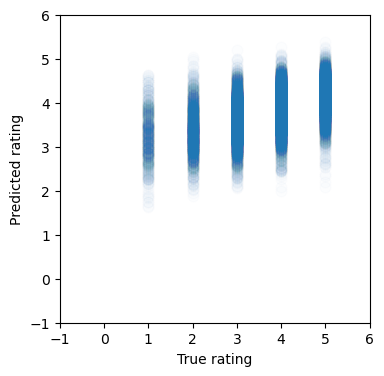

In [124]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

test_preds = model.predict([user_id_test_with_genre, item_id_test_with_genre, genres_test_with_genre], batch_size=64)
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test_with_genre))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test_with_genre))
plot_predictions(rating_test_with_genre, test_preds)